In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline

### 1. Loading the data

First, loading the migraine dataset as a pandas dataframe and taking a look at it.

In [60]:
df = pd.read_csv('migraine_diary2.csv', encoding='latin-1', sep=';')
df['Intensity'] = df['Intensity'].fillna(0)
# If there was a headache, but the intensity was not specified, assuming the intensity was 3
df['Intensity'] = np.where((df['Headache'] == 'y') & (df['Intensity'] == 0), 3, df['Intensity']) 
df['Date'] = pd.to_datetime(df['Date'], errors = 'coerce', format='%d.%m.%Y')
df.drop_duplicates(subset='Date', inplace=True)
df.head()

,Date,Headache,Intensity
0,2020-09-26,y,7.0
1,2020-09-27,n,0.0
2,2020-09-28,n,0.0
3,2020-09-29,n,0.0
4,2020-09-30,n,0.0


The dataframe has three columns: **Date**, **Headache** (whether there was a headache or not, y/n), and the **Intensity** of the pain on a scale from 0 to 10. \
Taking a look at the distribution of days with and without headache.

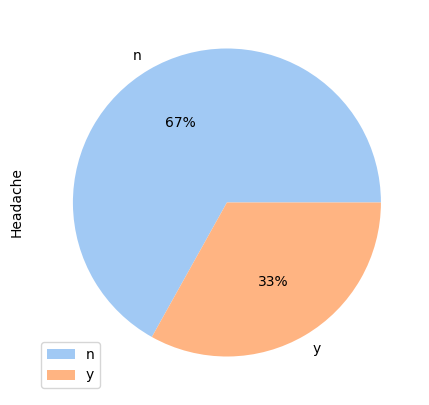

In [26]:
colors = sns.color_palette('pastel')
classes = pd.value_counts(df["Headache"])
classes.plot(kind='pie', figsize=(5,5), autopct='%0.f%%', legend=True, colors = colors)
plt.show() 

Then loading the period dataset in the same format and adding the period values to the created dataframe.

In [61]:
period_df = pd.read_csv('period_diary.csv', encoding='latin-1', sep=';')
period_df['date'] = pd.to_datetime(period_df['date'], errors = 'coerce', format='%d.%m.%Y')
period_df.drop_duplicates(subset='date', inplace=True)
df['Period'] = period_df['period']
df.head()

,Date,Headache,Intensity,Period
0,2020-09-26,y,7.0,y
1,2020-09-27,n,0.0,y
2,2020-09-28,n,0.0,y
3,2020-09-29,n,0.0,y
4,2020-09-30,n,0.0,y


In [5]:
df.Period.unique()

array(['y', nan, 'o'], dtype=object)

The **Period** column has three values: **y** for period, **o** for ovulation, and **nan** for no period. \
\
Taking a look at the dataset stats.

In [62]:
first_date = df.Date.iloc[0].date()
last_date = df.Date.iloc[-1].date()
delta = last_date - first_date
cycles = df.Period.value_counts()['o']

print('The journal starts on', first_date)
print('The journal ends on', last_date)
print('Total days:', delta.days)
print('Days without headache:', df.Headache.value_counts()['n'])
print('Days with headache:', df.Headache.value_counts()['y'])
print('Average headache intensity:', df[df.Intensity != 0].Intensity.mean())
print('Number of period cycles:', cycles)

The journal starts on 2020-09-26
The journal ends on 2022-04-24
Total days: 575
Days without headache: 384
Days with headache: 190
Average headache intensity: 4.110526315789474
Number of period cycles: 21


## 2. Preparing the data

Breaking down the data into 30-day periods. This will make for a clearer visualization, and also allow to test out the data preparation functions on a smaller partition of data rather than on the whole dataset.

In [63]:
months = delta.days // 28
split_dfs = np.array_split(df, months)
print('Number of chunks:', len(split_dfs))

Number of chunks: 20


In [22]:
'''In order to achieve a smooth plotline, 
this function breaks down days into hours 
and interpolates the migraine Intensity values by hour,
returning a new dataframe that is indexed by hour,
as well as the new indices list
'''

def migraine_hourly(df):
    
    startDate = list(df['Date'])[0]
    endDate = list(df['Date'])[-1]
    index = pd.date_range(startDate, endDate)
    data = list(df['Intensity'])
    cols =['Headache Intensity']

    df = pd.DataFrame(data, index=index, columns = cols)
    index_hourly = pd.date_range(startDate, endDate, freq='1H')
    df_hourly = df.reindex(index=index_hourly).interpolate(method='pchip')
    return df_hourly, index_hourly

Taking a look at the first chunk of the new dataframe indexed by hour. 

In [64]:
df_hourly, index_hourly = migraine_hourly(split_dfs[0])
df_hourly

,Headache Intensity
2020-09-26 00:00:00,7.000000
2020-09-26 01:00:00,6.562753
2020-09-26 02:00:00,6.127025
2020-09-26 03:00:00,5.694336
2020-09-26 04:00:00,5.266204
...,...
2020-10-23 20:00:00,0.000000
2020-10-23 21:00:00,0.000000
2020-10-23 22:00:00,0.000000
2020-10-23 23:00:00,0.000000


If we take a look at the plotline, it looks pretty smooth.

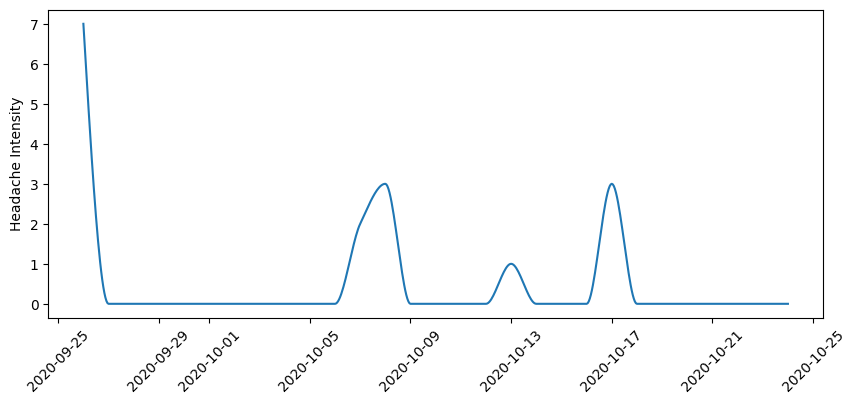

In [65]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(data=df_hourly, x=df_hourly.index, y = df_hourly['Headache Intensity'], ax=ax)
ax.tick_params(axis='x', labelrotation = 45)

In [66]:
'''Function that extracts dates of periods and ovulations
from the dataframe'''

def period_lists(df):
    y_dates=[]
    o_dates=[]
    for index, row in df.iterrows():
        if row['Period']=='y':
            date=row['Date'].date()
            y_dates.append(date)
        if row['Period']=='o':
            date=row['Date'].date()
            o_dates.append(date)
    return y_dates, o_dates

In [67]:
y_dates, o_dates = period_lists(split_dfs[0])
print('The period dates are:', y_dates)
print('The ovulation dates are:', o_dates)

The period dates are: [datetime.date(2020, 9, 26), datetime.date(2020, 9, 27), datetime.date(2020, 9, 28), datetime.date(2020, 9, 29), datetime.date(2020, 9, 30)]
The ovulation dates are: [datetime.date(2020, 10, 11)]


In [68]:
'''This function creates a list of values for the Period column
in the new hourly dataframe by checking if the dates 
are in the previously created lists of period and ovulation dates,
where y = period, n = no period, and o = ovulation,
and adding this list to the dataframe indexed by hours,
returning the dataframe'''

def period_hourly(df_hourly, y_dates, o_dates):
    period_list=[]
    for i in index_hourly:
        if i.date() in y_dates:
            period_list.append('y')
        elif i.date() in o_dates:
            period_list.append('o')
        else:
            period_list.append('n')
        
    df_hourly['Period']=period_list
    return df_hourly

In [69]:
df_hourly = period_hourly(df_hourly, y_dates, o_dates)
df_hourly.head()

,Headache Intensity,Period
2020-09-26 00:00:00,7.000000,y
2020-09-26 01:00:00,6.562753,y
2020-09-26 02:00:00,6.127025,y
2020-09-26 03:00:00,5.694336,y
2020-09-26 04:00:00,5.266204,y


After adding the **Period** column, I get the final dataframe that is ready for visualization.
Now one thing left to be done is to create lists containing timespans of periods to visualize them on the graph.

In [70]:
'''Function that accepts a dataframe indexed by hour
and returns a list of period labels enountered in it
and a list of lists of dataspans corresponding to each label
'''

def label_span(df_smooth_period):
    datespans=[]
    label0 = 'label'
    datespan = []
    labels=[]

    for index, row in df_smooth_period.iterrows():
        label = row['Period']    
        if label != label0:
            datespans.append(datespan)
            labels.append(label)
            datespan = []
            datespan.append(index)
            label0 = label
        elif label == label0:
            datespan.append(index)
    datespans.append(datespan)
    labels.append(label)

    del datespans[:1]
    del labels[-1:]
    
    return labels, datespans


In [71]:
labels, datespans = label_span(df_hourly)
print(labels, len(datespans))

['y', 'n', 'o', 'n'] 4


## 3. Visualizing the data

Now that I have all the necessary functions and have prepared the data, I can visualize it. 

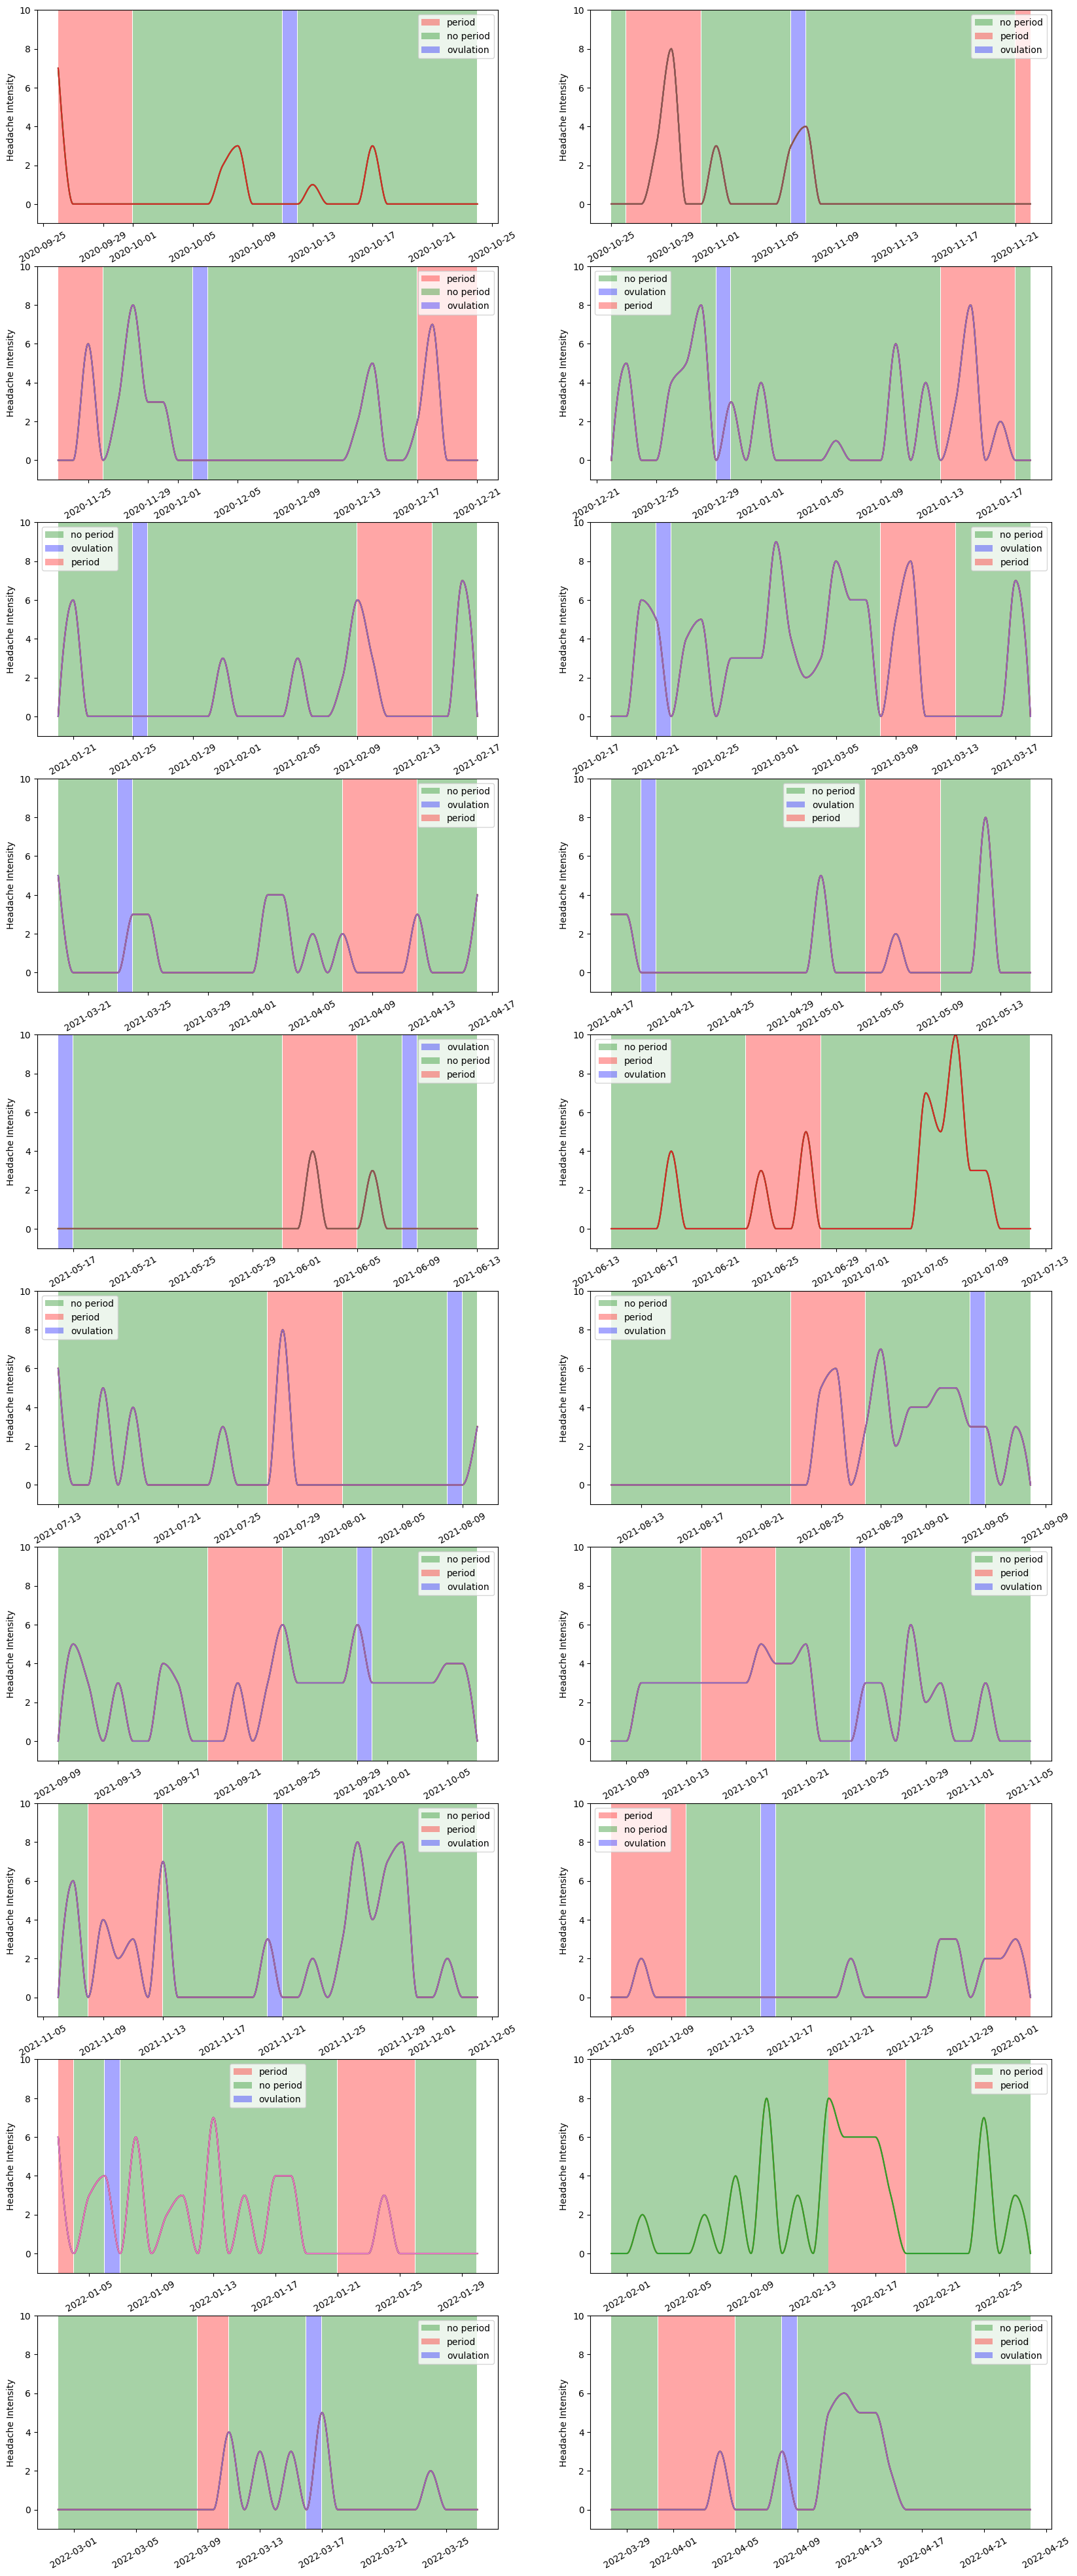

In [57]:
fig, axes = plt.subplots(nrows = 10, ncols =2)
fig.set_size_inches(20,50)
row_coord = 0
col_coord = 0
ind = 0

for df in split_dfs:
    df_hourly, index_hourly = migraine_hourly(df)
    y_dates, o_dates = period_lists(df)
    df_hourly = period_hourly(df_hourly, y_dates, o_dates)
    labels, datespans = label_span(df_hourly)
    ax = axes[row_coord, col_coord]

    y = df_hourly['Headache Intensity']
    ax.set_ylim([-1, 10])
    ax.tick_params(axis='x', labelrotation = 30)
    span_counts = {'y': 0, 'n': 0, 'o': 0}
    for label, span in zip(labels, datespans):
        if label=='y':
            ax.axvspan(span[0], span[-1], alpha=0.35, facecolor='red', label='_'*span_counts[label]+'period')
            span_counts[label]+=1
        if label=='n':
            ax.axvspan(span[0], span[-1], alpha=0.35, facecolor='green', label='_'*span_counts[label]+'no period')
            span_counts[label]+=1
        if label=='o':
            ax.axvspan(span[0], span[-1], alpha=0.35, facecolor='blue', label='_'*span_counts[label]+'ovulation')
            span_counts[label]+=1

        sns.lineplot(data=df_hourly, x=df_hourly.index, y=y, ax=ax)
 
    if ind % 2 == 0:
        col_coord = 1
    else:
        row_coord += 1
        col_coord=0
    ind += 1
    
